# Energy System Modelling - Tutorial V.3

**Generator dispatch with SciGRID**

[SciGRID](https://www.scigrid.de/pages/general-information.html) is a project that provides an open source reference model of the European transmission networks. In this tutorial, other than previous simple examples, you will examine the economic dispatch of generators all over Germany and its effect on the power system. The data files for this example and a populated Jupyter notebook are provided in `./data`.

The dataset comprises time series for loads and the availability of renewable generation at an hourly resolution for the year 2011. Feel free to choose a day to your liking; we will later discuss your different outcomes in groups. A few days might be of particular interest:
* `2011-01-31` was the least windy day of 2011
* `2011-02-05` was a stormy day with lots of wind energy production,
* `2011-07-12` the weather 7 years ago was a very sunny day, and
* `2011-09-06` was a windy *and* sunny autumn day.

***
## Data sources

* The **grid** is based on [SciGRID](http://scigrid.de/) Version 0.2 which is based on [OpenStreetMap](http://www.openstreetmap.org/).

* The **load size and location** is based on Landkreise (NUTS 3), GDP and population.

* The **load time series** is from ENTSO-E hourly data, scaled up uniformly by factor 1.12 (a simplification of the methodology in Schumacher, Hirth (2015)).

* **Conventional power plant capacities and locations** are taken from the BNetzA list.

* **Wind and solar capacities and locations** are retrieved from [EEG Stammdaten](http://www.energymap.info/download.html), which represents capacities at the end of 2014. Units without PLZ are removed.

* **Wind and solar time series** are derived from REatlas, Andresen et al, "Validation of Danish wind time series from a new global renewable energy atlas for energy system analysis," Energy 93 (2015) 1074 - 1088.

* All times in the dataset are UTC.

* Where SciGRID nodes have been split into 220kV and 380kV substations, all load and generation is attached to the 220kV substation.

## Disclaimer

There are several known problems and inaccuracy that limit the suitability of this example for research purposes. These include:

* Rough approximations have been made for missing grid data, e.g. 220kV-380kV transformers and connections between close sub-stations missing from OSM.

* There appears to be some unexpected congestion in parts of the network, which may mean for example that the load attachment method (by Voronoi cell overlap with Landkreise) isn't working, particularly in regions with a high density of substations.

* Attaching power plants to the nearest high voltage substation may not reflect reality.

* There is no proper n-1 security in the calculations - this can either be simulated with a blanket e.g. 70% reduction in thermal limits (as done here) or a proper [security constrained OPF](http://www.pypsa.org/examples/scigrid-sclopf.ipynb).

* The borders and neighbouring countries are not represented.

* Hydroelectric power stations are not modelled accurately.

* The marginal costs are illustrative, not accurate.

* The ENTSO-E total load for Germany may not be scaled correctly; it is scaled up uniformly by factor 1.12 (a simplification of the methodology in Schumacher, Hirth (2015), which suggests monthly factors).

* Biomass from the EEG Stammdaten are not read in at the moment.

* Power plant start up costs, ramping limits/costs, minimum loading rates are not considered.

***
## Imports

In [1]:
#make the code as Python 3 compatible as possible
#from __future__ import print_function, division, absolute_import
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.rcParams['figure.dpi']= 400
plt.style.use('bmh')
%matplotlib inline

## Parameters

Some general settings:

In [2]:
solver_name = "glpk"
contingency_factor = 0.7
group_size = 4
import_name = "data"

Specify the day you wish to look at here (any day in 2011):

In [3]:
day = "2011-07-11"

Some settings for plotting:

In [4]:
timesteps = np.arange(0,24,4)

n_graphs = len(timesteps)
n_cols = 3

if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1
    
size = 6 # inches

## Read Data

In [5]:
network = pypsa.Network(import_name=import_name)

Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network data has buses, generators, lines, loads, storage_units, transformers


There are some infeasibilities without allowing extension.

In [6]:
network.lines["s_nom_original"] = network.lines.s_nom

# extendable, but no reduction of line capacities
network.lines.s_nom_extendable = True
network.lines.s_nom_min = network.lines.s_nom

network.lines.capital_cost = 9999999 # EUR/MVA/km - prohibitively high penalty

Set network snapshots to chosen day.

In [7]:
network.set_snapshots(pd.date_range(start='{} 00:00:00'.format(day), end='{} 23:00:00'.format(day), freq='H'))

***
## (a) Describe the network as well as its regional and temporal characteristics.

### (a)-(i) | Plot the aggregated load curve.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


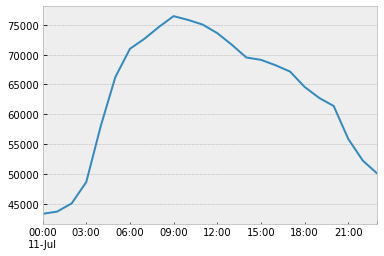

In [8]:
# TASK
network.loads_t.p_set.sum(axis=1).plot()

### (a)-(ii) | Plot the total generation capacities grouped by generation technology. Why is the share of capacity for renewables higher than the share of electricity produced?

In [9]:
network.generators.head()

,bus,p_nom,carrier,marginal_cost,control,type,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
1 Gas,1,121.0,Gas,50.0,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
1 Hard Coal,1,272.0,Hard Coal,25.0,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
102 Gas,102,67.9,Gas,50.0,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
108 Run of River,108,63.1,Run of River,3.0,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
108 Waste,108,38.0,Waste,6.0,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


<BarContainer object of 14 artists>

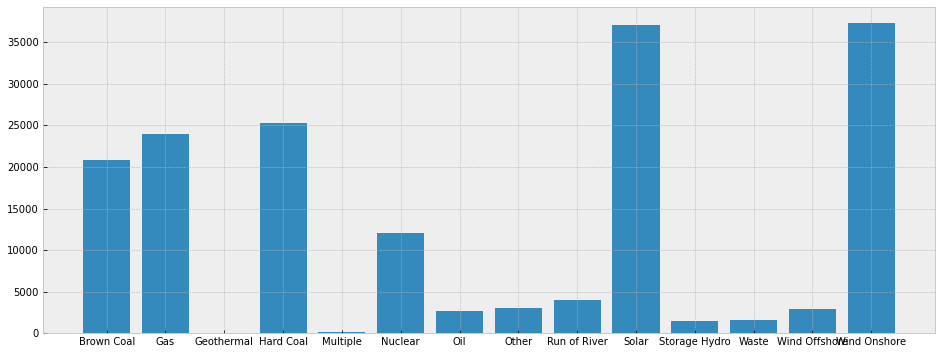

In [10]:
fig, ax = plt.subplots(figsize=(16,6))

# TASK
groups = network.generators.groupby("carrier").p_nom.sum()
plt.bar(groups.index,groups)

Renewable generators have lower [capacity factors / full load hours](https://en.wikipedia.org/wiki/Capacity_factor).

### (a)-(iii) | Plot the regional distribution of the loads for different snapshots. What are the major load centres?
> **Hint:** Use the pandas function `groupby`.

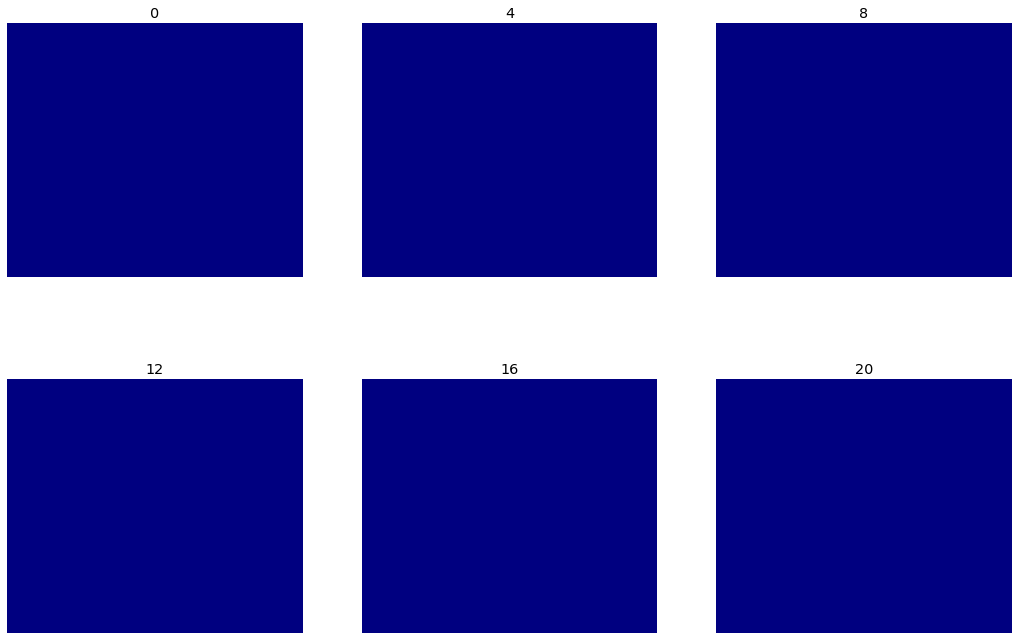

In [13]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                         figsize=(size*n_cols,size*n_rows),
                        subplot_kw={"projection":ccrs.PlateCarree()})

for i, timestep in enumerate(timesteps):
    i_row = i // n_cols
    i_col = i % n_cols
    
    ax = axes[i_row,i_col]
    
    # TASK
    load_distribution = network.loads_t.p_set.loc[network.snapshots[timestep]].groupby(network.loads.bus).sum()
    
    network.plot(bus_sizes=0.2*load_distribution,
                 ax=ax,title="Load distribution",
                 bus_colors='navy',
                 line_colors='firebrick',
                 color_geomap=True)
    
    ax.set_title(timestep)

### (a)-(iv) | Plot the regional distribution of generation technologies. Comment on what you see.

> **Hint:** Use the pandas functions `groupby` and `reindex`.

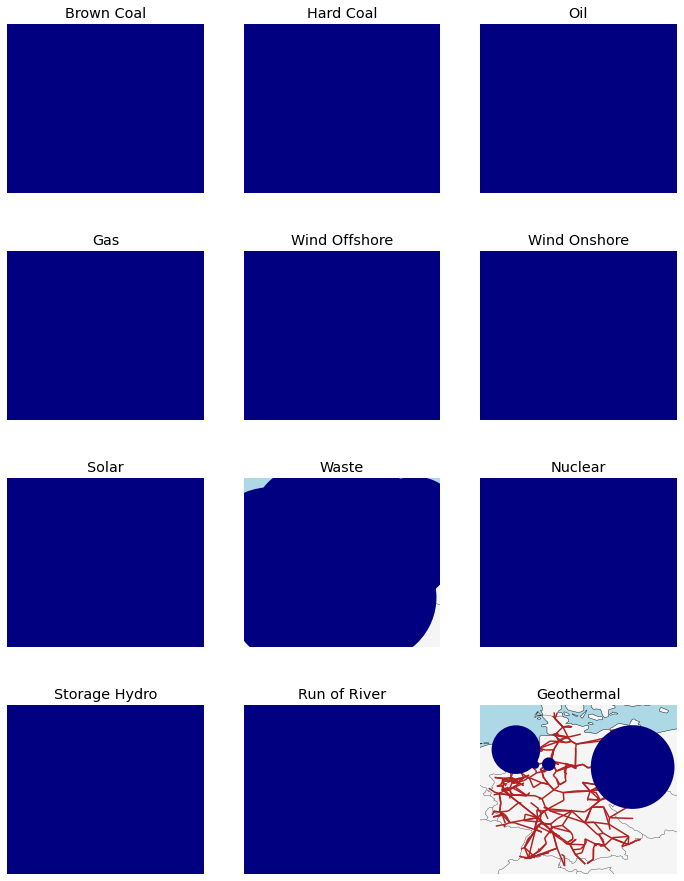

In [15]:
techs = ["Brown Coal","Hard Coal","Oil","Gas",
         "Wind Offshore","Wind Onshore","Solar","Waste",
         "Nuclear","Storage Hydro","Run of River", "Geothermal"]

width_factor = 4
height_factor = 4


n_graphs_g = len(techs)

n_cols_g = 3

if n_graphs_g % n_cols_g == 0:
    n_rows_g = n_graphs_g // n_cols_g
else:
    n_rows_g = n_graphs_g // n_cols_g + 1
    
fig, axes = plt.subplots(nrows=n_rows_g, ncols=n_cols_g,
                         figsize=(width_factor*n_cols_g,height_factor*n_rows_g),
                         subplot_kw={"projection":ccrs.PlateCarree()})


for i,tech in enumerate(techs):
    i_row = i // n_cols_g
    i_col = i % n_cols_g
    
    ax = axes[i_row,i_col]
    
    # TASK
    gens = network.generators[network.generators.carrier == tech]
    gen_distribution = gens.groupby("bus").p_nom.sum().reindex(network.buses.index, fill_value=0.)
    
    network.plot(ax=ax,
                 bus_sizes=0.2*gen_distribution,
                 bus_colors='navy',
                 line_colors='firebrick',
                 color_geomap=True)
    
    ax.set_title(tech)

***
## (b) Run a linear optimal power flow to obtain the economic dispatch and analyse the results.

### (b)-(i) | To approximate n-1 security and allow room for reactive power flows, set the maximum line loading of any line in the network to 70 % of their thermal rating.

In [16]:
# TASK
network.lines.s_nom = contingency_factor*network.lines.s_nom

In [17]:
# set the initial state of charge to zero
network.storage_units.state_of_charge_initial = 0.

for i in range(int(24/group_size)):
    
    
    if i>0:
        # set the initial state of charge based on previous round
        network.storage_units.state_of_charge_initial = network.storage_units_t.state_of_charge.loc[network.snapshots[group_size*i-1]]
        
    # solve linear optimal power flow
    network.lopf(network.snapshots[group_size*i:group_size*i+group_size],
                 solver_name=solver_name)
    
    # update line capacities
    network.lines.s_nom = network.lines.s_nom_opt

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2883305322289.5
  Upper bound: 2883305322289.5
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 10793
  Number of nonzeros: 39307
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 2.749401092529297
# ----------------------------------------------------------
#   Solution Information
# -------

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1224602604.5293
  Upper bound: 1224602604.5293
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 10793
  Number of nonzeros: 39307
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.5302631855010986
# ----------------------------------------------------------
#   Solution Information
# ------

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 350829750.197266
  Upper bound: 350829750.197266
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 10793
  Number of nonzeros: 39307
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 4.101136207580566
# ----------------------------------------------------------
#   Solution Information
# -----

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -622111360.408203
  Upper bound: -622111360.408203
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 10793
  Number of nonzeros: 39307
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 4.316533327102661
# ----------------------------------------------------------
#   Solution Information
# ---

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -393366212.078125
  Upper bound: -393366212.078125
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 10793
  Number of nonzeros: 39307
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.450228452682495
# ----------------------------------------------------------
#   Solution Information
# ---

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -541087182.347656
  Upper bound: -541087182.347656
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 10793
  Number of nonzeros: 39307
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.042311429977417
# ----------------------------------------------------------
#   Solution Information
# ---

### (b)-(ii) | Plot the hourly dispatch grouped by carrier for the chosen day. Comment on what you see.

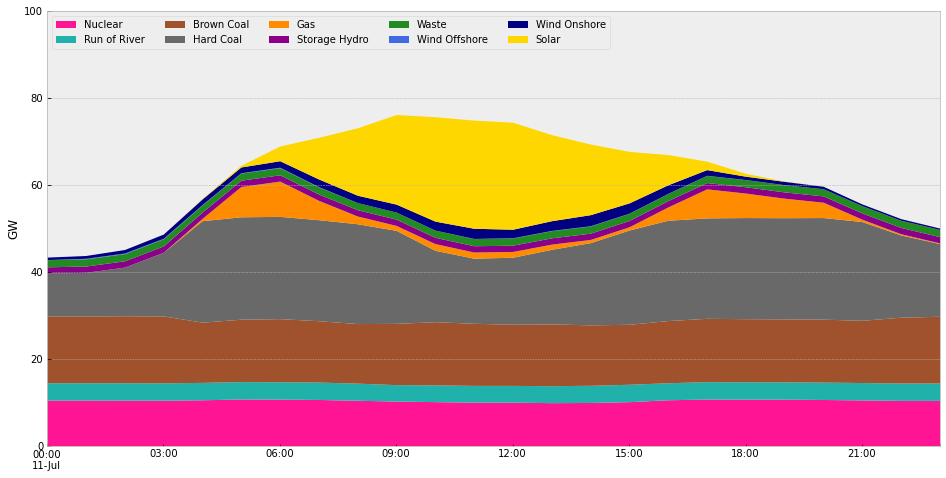

In [19]:
# TASK
p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
#reorder
cols = ['Nuclear', 'Run of River', 'Brown Coal', 'Hard Coal', 'Gas',
        'Storage Hydro', 'Waste', 'Wind Offshore', 'Wind Onshore', 'Solar']
p_by_carrier = p_by_carrier[cols]
p_by_carrier_gw = p_by_carrier / 1e3 # convert MW to GW

colors = {"Brown Coal" : "sienna",
          "Hard Coal" : "dimgrey",
          "Nuclear" : "deeppink",
          "Run of River" : "lightseagreen",
          "Wind Onshore" : "navy",
          "Solar" : "gold",
          "Wind Offshore" : "royalblue",
          "Gas" : "darkorange",
          "Waste" : "forestgreen",
          "Storage Hydro" : "darkmagenta"
          }

fig, ax = plt.subplots(figsize=(16,8))

p_by_carrier_gw.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns]
)

ax.legend(ncol=5, loc="upper left")

ax.set_ylabel("GW")

ax.set_ylim(0,100);

### (b)-(iii) | Plot the aggregate dispatch of the pumped hydro storage units and the state of charge throughout the day and describe how they are used throughout the day. 

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

# TASK
p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)

p_storage.plot(label="Pumped hydro dispatch", ax=ax)
state_of_charge.plot(label="State of charge", ax=ax)

ax.legend()
ax.set_ylabel("MWh")

### (b)-(iv) |  Show the line loadings for different snapshots on the network. Can you identify a regional concentration of highly loaded branches?

In [ ]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                         figsize=(size*n_cols,size*n_rows),
                         subplot_kw={"projection":ccrs.PlateCarree()})

for i,timestep in enumerate(timesteps):
    i_row = i // n_cols
    i_col = i % n_cols
    
    ax = axes[i_row,i_col]
    
    # TASK
    loading = network.lines_t.p0.loc[network.snapshots[timestep]]/network.lines.s_nom
    
    network.plot(ax=ax,
                 line_colors=abs(loading),
                 line_cmap=plt.cm.viridis,
                 title="Line loading",
                 bus_sizes=0,
                 color_geomap=True)
    
    ax.set_title(timestep)

### (b)-(v) |  Plot the locational marginal prices for snapshots on the network. What is the interpretation of high and low marginal prices? What do the geographical differences of nodal prices tell you about the regional generation capacity, load centres and the state of the transmission network?

In [ ]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                         figsize=(size*n_cols,size*n_rows),
                         subplot_kw={"projection":ccrs.PlateCarree()})

for i,timestep in enumerate(timesteps):
    i_row = i // n_cols
    i_col = i % n_cols
    
    ax = axes[i_row,i_col]
    
    network.plot(ax=ax,
                 line_widths=pd.Series(0.5,network.lines.index),
                 bus_sizes=0,
                 line_colors='firebrick',
                 color_geomap=True)
    
    # TASK
    marginal_prices = network.buses_t.marginal_price.loc[network.snapshots[timestep]]

    hb = ax.hexbin(
            network.buses.x,
            network.buses.y, 
            gridsize=20,
            C=marginal_prices,
            cmap=plt.cm.viridis
         )
    
    ax.set_title(timestep)

cb = fig.colorbar(hb, ax=axes.ravel().tolist())

mini = network.buses_t.marginal_price.min().min()
maxi = network.buses_t.marginal_price.max().max()

cb.set_label('Locational Marginal Price (EUR/MWh)') 

In [ ]:
network.buses_t.marginal_price.min().min()

In [ ]:
network.buses_t.marginal_price.max().max()

In [ ]:
network.buses_t.marginal_price.describe()

In [ ]:
# regional distribution
network.buses_t.marginal_price.mean().describe()

In [ ]:
# temporal distribution
network.buses_t.marginal_price.mean(axis=1).describe()

### (b)-(vi) |  In general, when is variable renewable electricity curtailed? Plot the curtailment for on- and offshore wind as well as for solar energy on the chosen day. Would there still be curtailment if there were unlimited transmission capacity? What happens to the nodal prices in this case?

> **Hint:** For testing what would happen if there were unlimited transmission capacity, set the cost associated with transmission expansion to zero and rerun LOPF.

In [ ]:
carriers =  ["Wind Onshore", "Wind Offshore", "Solar"]

n_graphs_g = len(carriers)
n_cols_g = 3
n_rows_g = 1
size_g = 6
   
fig, axes = plt.subplots(nrows=n_rows_g, ncols=n_cols_g,
                        figsize=(size_g*n_cols_g,size_g*n_rows_g))

for i,carrier in enumerate(carriers):
    i_col = i % n_cols_g
    
    ax = axes[i_col]
    
    capacity = network.generators.groupby("carrier").sum().at[carrier,"p_nom"]

    # TASK
    p_available = network.generators_t.p_max_pu.multiply(network.generators.p_nom)
    p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
    p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier

    p_df = pd.DataFrame({carrier + " available" : p_available_by_carrier[carrier],
                         carrier + " dispatched" : p_by_carrier[carrier],
                         carrier + " curtailed" : p_curtailed_by_carrier[carrier]})

    p_df[carrier + " capacity"] = capacity

    p_df[carrier + " curtailed"][p_df[carrier + " curtailed"] < 0.] = 0.

    (p_df[[carrier + " dispatched",carrier + " curtailed"]]/1e3).plot(kind="area",ax=ax,linewidth=0)
    (p_df[[carrier + " available",carrier + " capacity"]]/1e3).plot(ax=ax,linewidth=2)

    ax.set_xlabel("")
    ax.set_ylabel("Power [GW]")
    ax.legend()
    
    ax.set_title(carrier)

***
## (c) Perform a non-linear power flow (Newton-Raphson) on the injections determined by the linear optimal power flow.

> **Remark:** You can use the function [`network.pf()`](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/power_flow.html). In case you are interested, you can find a description of the Newton-Raphson load flow algorithm [here](http://nptel.ac.in/courses/Webcourse-contents/IIT-KANPUR/power-system/chapter_4/4_10.html). However, you will not need it for the exam.

For the non-linear power flow, we set the P to the optimised P from the linear optimal power flow.

In [ ]:
network.generators_t.p_set = network.generators_t.p_set.reindex(columns=network.generators.index)
network.generators_t.p_set = network.generators_t.p

Further, we set all buses to PV, since we do not know what the Q set points are.

In [ ]:
network.generators.control = "PV"

But we need some PQ buses so that the Jacobian does not break

In [ ]:
f = network.generators[network.generators.bus == "492"]
network.generators.loc[f.index,"control"] = "PQ"

Perform non-linear PF on the results of linear optimal power flow (LOPF).

In [ ]:
info = network.pf()

### (c)-(i) | Plot the regional and temporal distribution of reactive power feed-in. What is the consequence of reactive flows in terms of the network's transfer capacity?

In [ ]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                         figsize=(size*n_cols,size*n_rows),
                         subplot_kw={"projection":ccrs.PlateCarree()})

for i,timestep in enumerate(timesteps):
    i_row = i // n_cols
    i_col = i % n_cols
    
    ax = axes[i_row,i_col]
    
    # TASK
    q = network.buses_t.q.loc[network.snapshots[timestep]]
    
    bus_colors = pd.Series("firebrick", network.buses.index)
    bus_colors[q<0.] = "navy"
    
    network.plot(ax=ax,
                 bus_sizes=abs(q),
                 bus_colors=bus_colors,
                 title="Reactive power feed-in (red=+ve, blue=-ve)",
                 line_colors='grey',
                 color_geomap=True)
    
    ax.set_title(timestep)

### (c)-(ii) | Analyse whether the chosen security constraint for thermal line loading  was sufficient. What happens if you omit the security constraint or require an even higher security constraint?

> **Hint:** Using a histogram might be a good option to visualise the distribution of maximum line loadings.

In [ ]:
# TASK
(network.lines_t.p0/network.lines.s_nom*contingency_factor).abs().max().hist(bins=np.arange(0,2,0.1))

In [ ]:
# TASK 
(network.lines_t.p0 / network.lines.s_nom*contingency_factor).abs().max().max()